# 로지스틱회귀분석 실습 1: 이진분류 문제

## 1. 모듈 불러오기

In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

## Universal bank 데이터 설명
ID - 고객 고유번호 <br>
Age - 고객의 연령 (연속형) <br>
Experienc - 고객의 경력 (연속형) <br>
Incom - 고객의 연간 수입 (연속형) <br>
ZIP Code - 고객 주소 ZIP Code <br>
Family - 고객의 가족 규모 (연속형) <br>
CCAvg - 평균 신용 카드 지출 (연속형) <br>
Education - 교육 수준 (범주형 - 1: 대학교 졸업, 2: 대학원 졸업, 3: 고급/전문) <br>
Mortgag - 주택 모기지의 가치 (연속형) <br>
PersonalLoan - 고객은 마지막 캠페인에 제공된 개인 대출을 수락 하였나? (범주형 - 0: 아니오, 1: 예) <b>[타겟 변수]</b> <br>
SecuritiesAccount - 고객은 은행에 증권 계좌를 가지고 있는가? (범주형 - 0: 아니오, 1: 예) <br>
CDAccount - 고객은 은행에 예금 계좌를 가지고 있는가?	(범주형 - 0: 아니오, 1: 예) <br>
Online - 고객이 인터넷 뱅킹 시설을 사용하는가? (범주형 - 0: 아니오, 1: 예) <br>
CreditCard - 고객이 Universal Bank에서 발행 한 신용 카드를 사용하는가? (범주형 - 0: 아니오, 1: 예)

In [2]:
data = pd.read_csv('Data/UniversalBank.csv')
data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


## 2. 데이터 전처리 및 탐색적 데이터 분석

### ID와 ZIP Code는 예측에 필요하지 않은 변수이므로 제거

In [3]:
data = data.drop(['ID','ZIP Code'], axis=1)
data.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


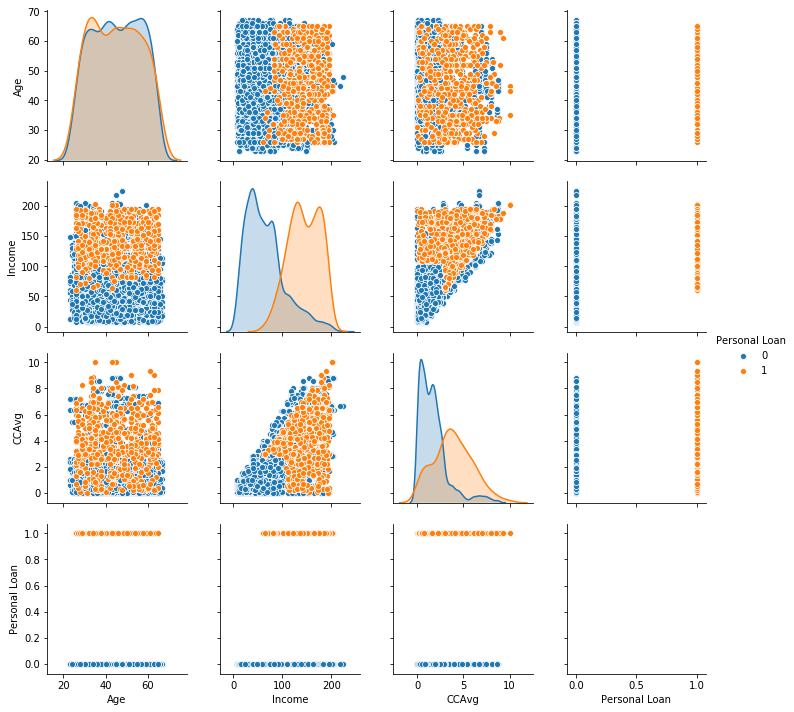

In [4]:
sns.pairplot(data[['Age', 'Income', 'CCAvg', 'Personal Loan']], hue="Personal Loan")
plt.show()

### Education 변수에 대한 더미 변수 생성

In [5]:
education_dummy = pd.get_dummies(data['Education'], drop_first=True)
education_dummy.columns = ['Edu_Dummy_1', 'Edu_Dummy_2']
display(education_dummy.head())

,Edu_Dummy_1,Edu_Dummy_2
0,0,0
1,0,0
2,0,0
3,1,0
4,1,0


### 기존 Education 변수 제거하고, 더미 변수 추가

In [6]:
data = data.drop('Education', axis=1)
data = pd.concat([data, education_dummy], axis=1)
data.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Edu_Dummy_1,Edu_Dummy_2
0,25,1,49,4,1.6,0,0,1,0,0,0,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,1,0


### 타겟 변수의 클래스 비율 확인

In [7]:
display(data['Personal Loan'].value_counts())

0    4520
1     480
Name: Personal Loan, dtype: int64

### 타겟 변수의 클래스 비율 유지하며 Train/Test 데이터 분리

In [8]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=55, stratify=data['Personal Loan'])
print('Training')
display(train_data['Personal Loan'].value_counts())
print('Testing')
display(test_data['Personal Loan'].value_counts())

Training


0    3164
1     336
Name: Personal Loan, dtype: int64

Testing


0    1356
1     144
Name: Personal Loan, dtype: int64

## 3. 모델링

In [9]:
model = sm.Logit(train_data['Personal Loan'], train_data.drop('Personal Loan', axis=1))
model_fitted = model.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.125694
         Iterations 9


In [10]:
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3488
Method:                           MLE   Df Model:                           11
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:                  0.6025
Time:                        00:05:09   Log-Likelihood:                -439.93
converged:                       True   LL-Null:                       -1106.7
                                        LLR p-value:                2.577e-279
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.4971      0.026    -18.837      0.000      -0.549      -0.445
Experience             0.5033      0.030     17.049      0.000       0.445       0.561
Income                 0.0554      0.003     16.552      0.000       0.049       0.062
Family                 0.5959      0.089      6.720      0.000       0.422       0.770
CCAvg                  0.1634      0.051      3.200      0.001       0.063       0.263
Mortgage               0.0012      0.001      1.777      0.076      -0.000       0.003
Securities Account    -1.0738      0.353     -3.041      0.002      -1.766      -0.382
CD Account             3.9235      0.404      9.701      0.000       3.131       4.716
Online                -0.6956      0.190     -3.654      0.000      -1.069      -0.322
CreditCard            -1.0158      0.243     -4.179      0.000      -1.492      -0.539
Edu_Dummy_1            3.7273      0.299     12.462      0.000       3.141       4.313
Edu_Dummy_2            3.9697      0.301     13.192      0.000       3.380       4.560
======================================================================================
"""

## 4. 모델 결과물 확인

### 로지스틱회귀분석 모델의 출력 값은 "클래스에 속할 확률"

In [11]:
train_prob = model_fitted.predict(train_data.drop('Personal Loan', axis=1))
train_results = pd.concat([train_prob, train_data['Personal Loan']], axis=1)
train_results.columns = ['Predicted Probability', 'Personal Loan']
display(train_results)

,Predicted Probability,Personal Loan
2464,0.007809,0
3704,0.973267,1
3505,0.029640,0
3806,0.000307,0
1497,0.022951,0
4639,0.001175,0
4170,0.000031,0
4594,0.003228,0
2396,0.000079,0
267,0.001413,0


In [12]:
test_prob = model_fitted.predict(test_data.drop('Personal Loan', axis=1))
test_results = pd.concat([test_prob, test_data['Personal Loan']], axis=1)
test_results.columns = ['Predicted Probability', 'Personal Loan']
display(test_results)

,Predicted Probability,Personal Loan
824,0.001071,0
4917,0.001668,0
3911,0.002829,0
3264,0.425924,0
1663,0.002302,0
3493,0.001678,0
2157,0.000864,0
4378,0.010208,0
2250,0.073248,0
2980,0.016544,0


### 확률 값을 기준으로 최종 클래스 결정 (0.5를 기준으로)

In [13]:
train_pred = (train_prob.values > 0.5).astype(np.float)
test_pred = (test_prob.values > 0.5).astype(np.float)

### Train 데이터에 대한 정확도

In [14]:
accuracy_score(train_data['Personal Loan'], train_pred)

0.9571428571428572

### Test 데이터에 대한 정확도

In [15]:
accuracy_score(test_data['Personal Loan'], test_pred)

0.9586666666666667

## 5. Classification 결과 평가

In [16]:
display(pd.DataFrame(confusion_matrix(train_data['Personal Loan'], train_pred), columns=[0,1], index=[0,1]))

,0,1
0,3130,34
1,116,220


In [17]:
display(pd.DataFrame(confusion_matrix(test_data['Personal Loan'], test_pred), columns=[0,1], index=[0,1]))

,0,1
0,1339,17
1,45,99


## 6. 클래스 판단 기준 바꿔보기

In [18]:
train_pred = (train_prob.values > 0.3).astype(np.float)
test_pred = (test_prob.values > 0.3).astype(np.float)
print('Train Accuracy: {:.3f}'.format(accuracy_score(train_data['Personal Loan'], train_pred)))
display(pd.DataFrame(confusion_matrix(train_data['Personal Loan'], train_pred), columns=[0,1], index=[0,1]))
print('Test Accuracy: {:.3f}'.format(accuracy_score(test_data['Personal Loan'], test_pred)))
display(pd.DataFrame(confusion_matrix(test_data['Personal Loan'], test_pred), columns=[0,1], index=[0,1]))

Train Accuracy: 0.951


,0,1
0,3074,90
1,83,253


Test Accuracy: 0.955


,0,1
0,1320,36
1,32,112


In [19]:
train_pred = (train_prob.values > 0.1).astype(np.float)
test_pred = (test_prob.values > 0.1).astype(np.float)
print('Train Accuracy: {:.3f}'.format(accuracy_score(train_data['Personal Loan'], train_pred)))
display(pd.DataFrame(confusion_matrix(train_data['Personal Loan'], train_pred), columns=[0,1], index=[0,1]))
print('Test Accuracy: {:.3f}'.format(accuracy_score(test_data['Personal Loan'], test_pred)))
display(pd.DataFrame(confusion_matrix(test_data['Personal Loan'], test_pred), columns=[0,1], index=[0,1]))

Train Accuracy: 0.889


,0,1
0,2814,350
1,38,298


Test Accuracy: 0.911


,0,1
0,1237,119
1,15,129


## 7. Classification 결과 평가 심화

In [20]:
import pycm

train_pred = (train_prob.values > 0.3).astype(np.int)
test_pred = (test_prob.values > 0.3).astype(np.int)

cm = pycm.ConfusionMatrix(test_data['Personal Loan'].values, test_pred)

In [21]:
print(cm)

Predict    0          1          
Actual
0          1320       36         

1          32         112        





Overall Statistics : 

95% CI                                                            (0.94414,0.96519)
AUNP                                                              0.87561
AUNU                                                              0.87561
Bennett S                                                         0.90933
CBA                                                               0.8651
Chi-Squared                                                       826.0757
Chi-Squared DF                                                    1
Conditional Entropy                                               0.23317
Cramer V                                                          0.7421
Cross Entropy                                                     0.45624
Gwet AC1                                                          0.945
Hamming Loss                                   